# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
plt.style.use('ggplot')

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }

plt.rcParams.update(params)

import pandas as pd
from pandas import json_normalize

import plotly.express as px
import plotly.graph_objects as go

pd.options.mode.chained_assignment = None
pd.options.display.max_rows = 500
pd.options.display.max_seq_items = 500

import numpy as np
np.random.seed(42)

from bs4 import BeautifulSoup

import logging
import re
import copy
import os
import sys
import json
from datetime import datetime
from collections import Counter
import string
import glob
import ast
from tqdm.notebook import tqdm
import xmltodict

from tabulate import tabulate

from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

import scipy.spatial.distance

import umap

TITLE_SIZE = 24
TITLE_PAD = 20

DEFAULT_COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [3]:
# ----------- NLP modules ----------- #

# Setting up the environment and proper dependencies for top2vec on an ARM M1 Mac is quite difficult.
# gensim 3.8.3 and numpy 1.22 is needed. It seems best to work from this and install all other necessary packages for top2vec one by one with conda.
# We also need to install jupyterlab support for plotly with pip install jupyter-dash.
from top2vec import Top2Vec

# Modelling with Top2Vec
---

[Top2Vec](https://github.com/ddangelov/Top2Vec) is an algorithm for topic modeling and semantic search. According to its documentation, it *«automatically detects topics present in text and generates **jointly embedded topic, document and word vectors**.»*

With a trained Top2Vec model we can: 
- Identify topics and their sizes.
- Search topics by keywords.
- Search documents by topic or keyword(s).
- Find similar words.
- Find similar documents.

The algorithm automatically finds an appropiate number of topics. In terms of text cleaning, no stop word lists are required and there is no need for stemming/lemmatization.

The package even facilitates [exposing the model as an API](https://github.com/ddangelov/RESTful-Top2Vec).

Vectors are either created with Doc2Vec (which we already have used in the previous notebook), Tensorflow's [Universal Sentence Encoder](https://tfhub.dev/google/collections/universal-sentence-encoder/1) or with [BERT Sentence Transformer](https://www.sbert.net/). 

## How does the algorithm work?

The algorithm works in these steps:

1. Create jointly embedded document and word vectors (using one of the three algorithms mentioned above).
2. Reduce dimensionality with UMAP.
3. Identify dense areas with [HDBSCAN](https://github.com/scikit-learn-contrib/hdbscan).
4. Calculate the centroid of document vectors for each dense area in the original dimensionality (not reduced by UMAP).
5. Find n-closest word vectors to topic vector – which are the «topic words».

# Load and prepare data

In [3]:
df = pd.read_parquet("_data/podcasts_cleaned.parq")

# Remove all podcast that weren't updated after 2018.
df.releaseDate = pd.to_datetime(df.releaseDate)
to_drop = df[df.releaseDate.dt.year<2019].index
df.drop(to_drop, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(6636, 29)

I'll join texts in all relevant feature columns into one single text feature.

In [4]:
def join_text_columns(data):
    text = []
    for row in data.values:
        if type(row) is str:
            text.append(row)
        elif isinstance(row, (np.ndarray, list)):
            text.append(" ".join(row))
        else:
            assert row is None
            text.append("")
            continue
    return " ".join(text) 

In [5]:
podcast_columns = ['artistName', 'title', 'subtitle', 'summary', "tags", 
                   'ep_titles', 'ep_itunes_titles', 'ep_tags', 'primary_genre',
                   'ep_subtitles', 'ep_summaries', 'ep_contents']
df_pod = df[podcast_columns].apply(join_text_columns, axis=1)    

Though the creators of Top2Vec state, that basically no data cleaning is necessary I nonetheless clean the worst bits in the data:

- [X] Cut the word count per podcast to 10k
- [X] Remove HTML tags
- [X] Keep only ASCII + European Chars, some punctuation and whitespace
- [X] Remove links

In [6]:
RE_ASCII = re.compile(r"[^A-Za-zÀ-žäüöÄÜÖ.!? ]", re.IGNORECASE)
MAX_WORDS = 10_000
REMOVE_LESS_THAN = 2

def clean_text(text):
    
    # Reduce to MAX_WORDS to speed up processing.
    text = " ".join(text.split(" ")[:MAX_WORDS])
    
    # Strip HTML tags.
    text = BeautifulSoup(text, "lxml").get_text()
    
    # Keep only ASCII + European Chars, some punctuation and whitespace
    text = re.sub(RE_ASCII, " ", text)
   
    # Remove links.
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'www.\S+', ' ', text)
    
    # # Remove all words less than 2 digits long.
    # text = " ".join([token for token in text.split(" ") if len(token)>REMOVE_LESS_THAN])
       
    return text

In [7]:
%%time
df_pod = df_pod.apply(clean_text)
df["text"] = df_pod

CPU times: user 29.3 s, sys: 986 ms, total: 30.3 s
Wall time: 30.6 s


# Train a Top2Vec model

I train the model with the default parameters of 40 epochs and a minimal count of 50 word occurrences.

In [12]:
%%time
# Train model with default embedding of Doc2Vec
model = Top2Vec(df.text.values, min_count=50, workers=8)

In [13]:
model.save("_models/top2vec_doc2vec_eps40_min50")

# Analyze results

The algorithm has found 69 topics in the data.

In [5]:
model = Top2Vec.load("_models/top2vec_doc2vec_eps40_min50")

# save vectors for later use
doc_vectors = model._get_document_vectors()
tmp = pd.DataFrame(doc_vectors)
tmp.columns = tmp.columns.astype(str)
tmp.to_parquet("_models/vectors_top2vec.parq")

In [9]:
print(f"Top2Vec has identified {model.get_num_topics()} topics in the data.")

Top2Vec has identified 69 topics in the data.


In [10]:
topic_sizes, topic_nums = model.get_topic_sizes()
pd.DataFrame(topic_sizes, index=topic_nums, columns=["Count of docs in topic"]).head(10)

Count of docs in topic
0                     453
1                     406
2                     365
3                     276
4                     183
5                     179
6                     178
7                     173
8                     168
9                     166

## Examine topic composition

By printing the 50 closest words to a given topic center I get a quite precise impression of the semantic composition.
- The first topic obviously is related to news, current affairs and politics.
- The second seems to be related to comedy and fun.
- The three others likely are psychology & mindfulness, sports and sales & marketing.

Note: Top2Vec by default uses gensim's `simple_preprocess` function as the tokenizer (if we embed with Doc2Vec). There all accents are removed and all words are lowercased.

In [11]:
# Print the top 50 corresponding words for the top 3 topics.
for idx in range(5):
    print(model.get_topics(num_topics=5)[0][idx])
    print()

['regierung' 'politische' 'debatte' 'politik' 'politischen' 'partei'
 'politiker' 'bundesregierung' 'afd' 'parteien' 'staat' 'bundestag'
 'demokratie' 'kanzlerin' 'koalition' 'wahlkampf' 'bevolkerung'
 'politologe' 'opposition' 'cdu' 'spd' 'parlament' 'politischer'
 'demokratischen' 'parteitag' 'bundeskanzlerin' 'afghanistan' 'mehrheit'
 'proteste' 'fdp' 'belarus' 'bundeskanzler' 'protesten' 'reformen'
 'liberalen' 'demonstrationen' 'debatten' 'maßnahmen' 'linken' 'regieren'
 'demokratische' 'historiker' 'vorsitz' 'lukaschenko' 'linkspartei' 'csu'
 'politikern' 'nato' 'grunen' 'putin']

['naja' 'sorry' 'bisschen' 'scheiße' 'achja' 'mal' 'ja' 'wisst' 'labern'
 'leute' 'kacke' 'laber' 'reden' 'geil' 'seid' 'lol' 'dumm' 'nen'
 'lustige' 'gelacht' 'hab' 'klo' 'comedy' 'witze' 'irgendwie' 'ach'
 'ansonsten' 'scheiß' 'nem' 'echt' 'achso' 'haha' 'drauf' 'arschloch'
 'dumme' 'fresse' 'quatsch' 'lustigen' 'leider' 'unfassbar' 'ballern'
 'gags' 'ordentlich' 'tja' 'krass' 'trash' 'komisch' 'trotz

## Search for topic by keywords

We easily can search for arbitrary keywords and get the top related topics with their top related terms.

In [13]:
keyword = "marathon"
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=[keyword], num_topics=5)
for words in topic_words:
    print(words)
    print()

['halbmarathon' 'laufen' 'bestzeit' 'laufschuhe' 'laufer' 'triathlon'
 'marathons' 'lauf' 'laufsport' 'marathon' 'triathleten' 'langdistanz'
 'lauferinnen' 'strava' 'lauferin' 'ironman' 'ultramarathon' 'laufschuh'
 'triathlet' 'trainingsplane' 'trailrunning' 'trainingslager' 'intervalle'
 'running' 'ausdauerwelt' 'runners' 'lauftraining' 'fitschen'
 'trainingsplan' 'km' 'ultra' 'wettkampf' 'wettkampfe' 'weltrekord' 'run'
 'ultratrail' 'ausdauersport' 'ausdauerblog' 'gruning' 'wechselzone'
 'wettkampfen' 'endurance' 'trail' 'asics' 'lenertz' 'triathlonsport'
 'geesmann' 'leichtathletik' 'gelaufen' 'fatgirls']

['rennrad' 'rad' 'bike' 'gravel' 'gravelbike' 'bikes' 'bikepacking'
 'eurobike' 'mtb' 'fahrrad' 'mountainbike' 'radfahren' 'sram' 'roadbike'
 'roubaix' 'tubeless' 'radsport' 'enduro' 'radreise' 'zwift' 'downhill'
 'komoot' 'uci' 'radfahrer' 'shimano' 'tour' 'radrennen' 'radprofi'
 'rader' 'cycling' 'etappen' 'giro' 'ebike' 'mountainbiker'
 'fahrradpolitik' 'wahoo' 'france' 'lasten

## Get the most representative documents for a topic

It's also easy to retrieve to most relevant document for a given topic. Here I query topic `0`, which is the news topic.

In [14]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=0, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Doc #{doc_id}, {score:.3f}")
    print(doc[:100])
    print()

Doc #881, 0.579
Westdeutscher Rundfunk WDR   Mittagsecho Was ist Spannendes los in der Welt? Im Mittagsecho bieten w

Doc #388, 0.579
Redaktion NachDenkSeiten NachDenkSeiten   Die kritische Website NachDenkSeiten   Die kritische Websi

Doc #686, 0.564
Bayerischer Rundfunk BR   Thema des Tages Fundiert  informativ  tiefgründig  Im Thema des Tages von 

Doc #1208, 0.552
Deutschlandfunk Deutschlandfunk   Der Tag   Deutschlandfunk Die Beiträge zur Sendung  info news   . 

Doc #221, 0.551
hr iNFO hr iNFO Das Thema   aktuelles gesellschaft hessischer rundfunk hintergrund hintergründe hr h

Doc #899, 0.551
Deutschlandfunk Nova Kurz und Heute   Deutschlandfunk Nova Die Beiträge zur Sendung  info news   pol

Doc #3490, 0.547
Epoch Times Deutschland ETDPODCAST Der Epoch Times Podcast wird von der Epoch Times Europe GmbH hera

Doc #95, 0.546
SR Bilanz am Abend Aktuelles und Hintergründe zu Themen des Tages von Montag bis Freitag ab   .   Uh

Doc #1185, 0.538
ZEIT ONLINE Was jetzt? Der Nachrichten

## Search for podcasts by keywords

Even more interesting is it to retrieve podcasts by one or many keywords.

In [15]:
documents, document_scores, document_ids = model.search_documents_by_keywords(keywords=["kinder", "geschichte"], num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print(doc[:100])
    print()

Document: 4013, Score: 0.4324081540107727
Berit Huyke Der Bücherspatz DEIN Podcast rund um die schönsten Vorlesebücher DER Podcast rund um die

Document: 1559, Score: 0.3423457145690918
ELTERN   Audio Alliance ELTERNgespräch Ihr habt Fragen rund ums Familienleben? Dann schreibt uns eur

Document: 4386, Score: 0.33962205052375793
sigikid Geschichten für Kinder von     Jahren by sigikid   First Class for Kids Endlich gibt es die 

Document: 1654, Score: 0.32109326124191284
Anne Gute Nacht  Sonnenschein. Der Märchen Podcast.  Gute Nacht  Sonnenschein. Der märchenhafte Podc

Document: 2384, Score: 0.32091182470321655
Judetta   Mutterhelden In    Minuten aus dem Mamsterrad   Der Podcast Quickie für Mamas  Mama sein i

Document: 3311, Score: 0.31745558977127075
Julep Studios Alte Märchen Hallo liebe Märchen Freunde! In diesem Podcast lesen wir Euch die schönst

Document: 4415, Score: 0.3172687292098999
Marco König Ab ins Bett   Die tägliche Gute Nacht Geschichte Der Kinder Podcast Die Kinder

## Search similar podcasts to a given podcast

Interesting here is the option to provide negative examples too – e.g. *«I like podcast "X" but not "Y" and "Z.»*

In [16]:
podcast_id = df[df.title.str.contains("Finanzfluss", case=False)].index.tolist()

documents, document_scores, document_ids = model.search_documents_by_documents(podcast_id, num_docs=10)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print(doc[:100])
    print()

Document: 643, Score: 0.6257570385932922
Albert Warnecke und Daniel Korth Der Finanzwesir rockt   Der etwas andere Podcast über Geld und fina

Document: 597, Score: 0.552726149559021
Daniel Korth   Finanz Blogger  Podcaster und Co Host von  Der Finanzwesir rockt  Finanzrocker   Dein

Document: 513, Score: 0.5451347231864929
Stefan Obersteller Geldbildung.de   Finanzielle Bildung über Börse und Wirtschaft Finanzielle Bildun

Document: 5564, Score: 0.5084413886070251
Albert Warnecke und Daniel Korth El Dinero   Damit Dir Geldanlage nicht spanisch vorkommt!  Wir  Dan

Document: 4470, Score: 0.4948040246963501
Saidi von Finanztip Geld ganz einfach   Der Podcast mit Saidi von Finanztip  Wie kriegst Du es hin  

Document: 3389, Score: 0.4901827573776245
Talerbox Talerbox   Invest smart statt hart! Aktien  Börse  Geld anlegen oder Finanzen? Du willst me

Document: 4088, Score: 0.48215579986572266
extraETF.com extraETF Podcast   Erfolgreiche Geldanlage mit ETFs  Im extraETF Podcast erfährst du

## Search for similar keywords

If we wanted to inspire search by providing semantically similar keywords, we can retrieve these too with Top2Vec.

In [17]:
# Search for similar words to a given keyword.
words, word_scores = model.similar_words(keywords=["marathon"], keywords_neg=[], num_words=20)
for word, score in zip(words, word_scores):
    print(f"{word} {score:.2f}")

laufen 0.70
halbmarathon 0.68
marathons 0.66
bestzeit 0.65
laufschuhe 0.64
laufer 0.63
weltrekord 0.62
laufsport 0.60
running 0.60
lauf 0.59
lauferinnen 0.58
lauferin 0.56
ultra 0.55
strava 0.55
trainingslager 0.55
langdistanz 0.54
laufschuh 0.54
asics 0.53
run 0.53
ironman 0.53


# Plot the document vectors with UMAP

In [11]:
doc_vectors = model._get_document_vectors()
topic_labels = model.get_documents_topics(list(range(len(df))))[0]

In [12]:
umapper = umap.UMAP(n_neighbors=50, random_state=42)
embed_umap = umapper.fit_transform(doc_vectors)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
df_embed_umap = pd.DataFrame(embed_umap[:, :2], columns=["x", "y"])
df_embed_umap["labels"] = df.primary_genre

# Add some more features from the original dataframe to extend the hover labels in the plotly graph.
df_embed_umap["artistName"] = df.artistName
df_embed_umap["title"] = df.title
df_embed_umap["subtitle"] = df.subtitle
df_embed_umap["summary"] = df.summary

The plot provides its value mainly by allowing an interactive exploration of the hover labels of individual data points.

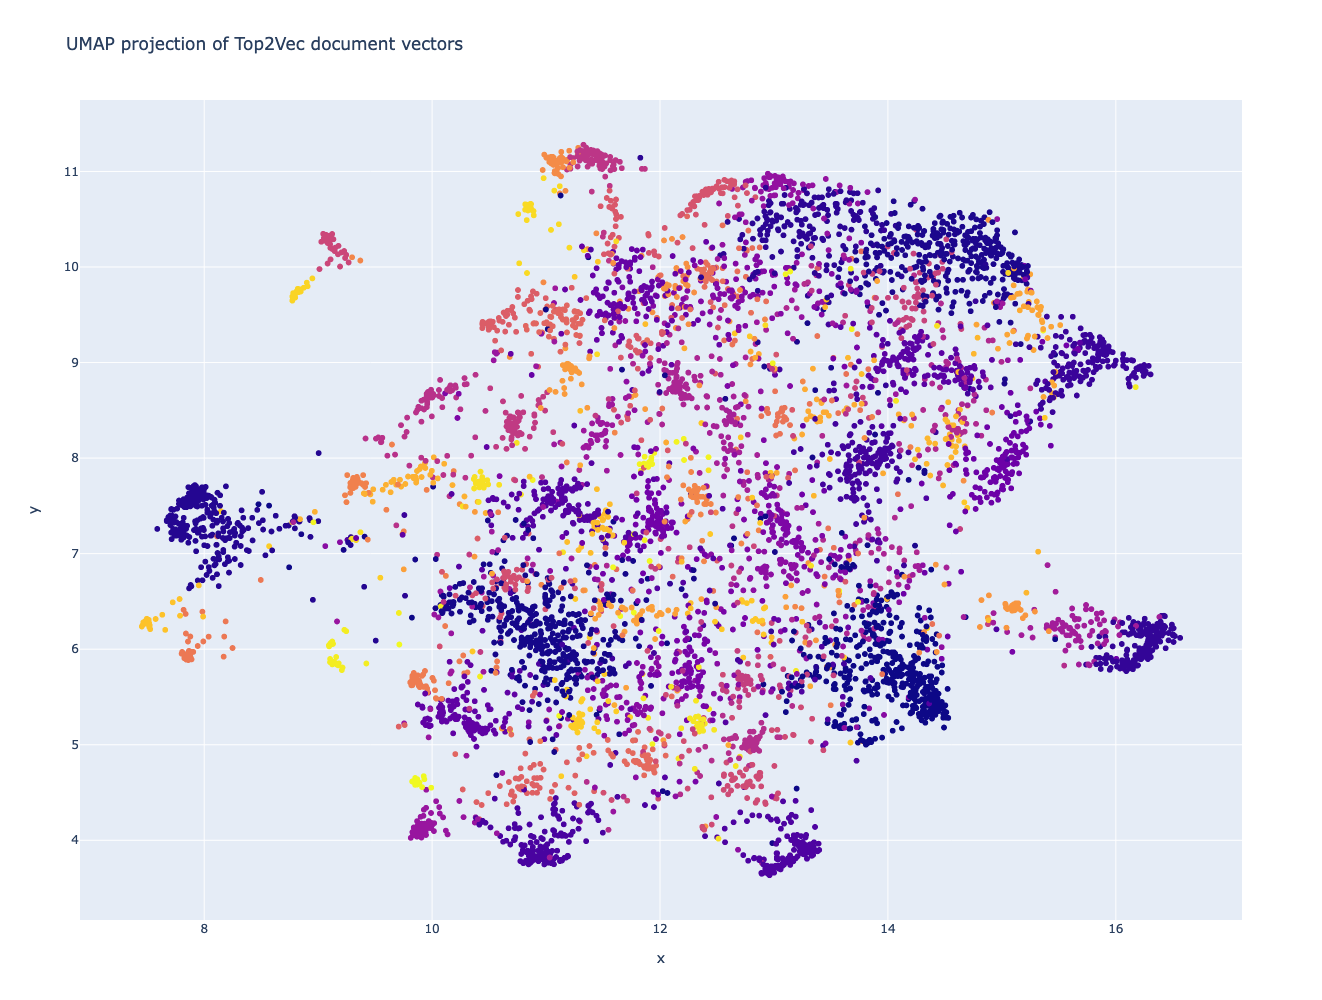

In [14]:
fig = px.scatter(data_frame=df_embed_umap, 
                 x="x", y="y", 
                 width=1400, height=1000,
                 color=topic_labels,
                 title="UMAP projection of Top2Vec document vectors",
                 hover_data=df_embed_umap[["artistName", "title"]], 
                )
fig.update_coloraxes(showscale=False)
fig.show()

# Conclusions

- **Top2Vec provides a simple workflow that abstracts away a lot of details in the generic gensim Doc2Vec workflow.**
- In addition **we get a joined embedding for topic, documents and words alike**. **This makes the resulting vector space much more flexible and useful.**
- The results are meaningful and promising in regard to the project goal.
- The search functionality of the package is interesting in regard to a potential search and recommendation application. 
- Training with medium quality settings took around an hour.
- Top2Vec offers support for much faster embeddings with Universal Sentence Encoder and BERT Sentence Transformer. Unfortunately I wasn't able to install the necessary packages on my Mac mini with ARM M1 processor and therefore couldn't try this out.
- Setting up a working conda environment for top2vec is time consuming and quite fragile. See comments in section `Imports` above.